# Stochastic stranding: Spam edition
__Суммарное количество баллов: 10__

По бескрайним каменным джунглям от заказа к заказу бродят курьеры. Их задача - как можно быстрее доставить все заказы, чтобы взять новые. Ничто не может заставить их покинуть вечный цикл доставки.
Курьеры часто они получают фейковые спам-рассылки, и чтобы помочь им отфильтровать сообщения, необходимо научиться отличать спам от не-спама.

In [6]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
import copy
from sklearn.model_selection import train_test_split
import spacy
from nltk.stem.snowball import SnowballStemmer
from typing import NoReturn

In [7]:
def get_colors(distances, alpha=True):
    normed = np.array(distances) - np.min(distances)
    normed = normed / np.max(normed)
    alpha = 1/np.mean([len(row) for row in normed])**0.5 if alpha else 1.
    return [[((1. if n > 0.5 else 2 * n), (1. if n < 0.5 else 2 - 2*n), 0., alpha) 
             for n in row] for row in normed]

def get_coords(points):
    results = []
    for pts in points:
        x_prev, _ = pts[0]
        result = [pts[0]]
        for x, y in list(pts[1:]) + [pts[0]]:
            result.append((x_prev, y))
            result.append((x, y))
            x_prev = x
        results.append(list(zip(*result)))
    return results

def init_figure(X):
    upper_bound, lower_bound = X.max(axis=0) + 1, X.min(axis=0) - 1
    fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
    #ax.set_facecolor((0.1, 0.1, 0.1))
    ax.grid(True)
    #ax.grid(True, color=(0.9, 0.9, 0.9))
    ax.set_xticks(range(lower_bound[0], upper_bound[0]))
    ax.set_yticks(range(lower_bound[1], upper_bound[1]))
    ax.set_xlim(lower_bound[0], upper_bound[0])
    ax.set_ylim(lower_bound[1], upper_bound[1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.scatter(X[:, 0], X[:, 1], color=(0, 0, 1))
    plt.tight_layout()
    return fig, ax    

def visualize_hillclimb(X, hillclimb):
    fig, ax = init_figure(X)
    permutations = hillclimb.optimize_explain(X)
    colors = get_colors([[cyclic_distance(X[p], hillclimb.dist) for p in permutations]], False)[0]
    coords = get_coords([X[p] for p in permutations])
    plot = ax.plot(coords[0][0], coords[0][1], color=colors[0])[0]
    
    def animate(i):
        plot.set_color(colors[i])
        plot.set_data(*coords[i])
        return (plot,)
    
    return animation.FuncAnimation(fig, animate, frames=len(permutations), interval=100, blit=True)

def visualize_genetic(X, genetic):
    fig, ax = init_figure(X)
    populations = genetic.optimize_explain(X)
    distances = [[cyclic_distance(X[p], genetic.dist) for p in populations[i]] for i in range(len(populations))]
    colors = get_colors(distances)
    coords = get_coords([X[p] for p in populations[0]])
    plots = [ax.plot(x, y, color=c)[0] for (x, y), c in zip(coords, colors[0])]
    best_id = np.argmin(distances[0])
    best_plot = ax.plot(*coords[best_id], color=(0.3, 0.3, 1, 0.9), linestyle="-.")[0]
    
    def animate(i):
        coords = get_coords([X[p] for p in populations[i]])
        for p, (x, y), c in zip(plots, coords, colors[i]):
            p.set_color(c)
            p.set_data(x, y)
        best_id = np.argmin(distances[i])
        best_plot.set_data(*coords[best_id])
        return plots + [best_plot]
    
    return animation.FuncAnimation(fig, animate, frames=len(populations), interval=100, blit=True)

import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [8]:
X, y = read_dataset("spam")
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(X, y, train_size=0.9)

C:\Users\Богиня\AppData\Local\Temp\ipykernel_14184\68973534.py:80: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(x, dtype=np.str), np.array(y, dtype=np.str)


In [9]:
def synthetic_points(count=25, dims=2):
    return np.random.randint(40, size=(count, dims))

X = synthetic_points()

In [10]:
%load_ext autoreload
%autoreload 2

### Задание 1 (1 балл)
Для начала научимся считать расстояния, которые курьерам придется преодолеть. Если бы они доставляли еду в пустыне, то им бы было достаточно считать евклидовы расстояния, т.к. можно просто идти напрямик. Однако курьеры доставляют еду только в городе, и двигаться могут только вдоль улиц. Поэтому нам понадобится манъэттенское расстояние.

#### Функции
`cyclic_distance(points, dist)` - возвращает суммарное расстояние пройденное курьером по циклу из точек `points` посчитанное при помощи функции `dist`.

`l2_distance(p1, p2)` - возвраает евклидово расстояние между точками.

`l1_distance(p1, p2)` - возвращает манхэттенское расстояние между точками.

In [11]:
from task import cyclic_distance, l2_distance, l1_distance

### Задание 2 (2 балла)
Курьер получил карту расположения заказов на карте. Ему хочется побыстрее обойти все точки. Для этого он хочет воспользоваться методом HillClimb, а вам предстоит ему в этом помочь. Реализуйте данный метод.

#### Методы
`optimize_explain(X)` - возвращает список из перестановок точек `X`, полученных в процессе оптимизации. Перестановка должна попадать в список после каждого изменения. Метод должен совершить не больше `max_iterations` итераций, на каждой из них необходимо рассмотреть все возможные пары индексов.

#### Параметры конструктора
`max_iterations` - максимальное количество итераций в методе `optimize_explain`

`dist` - функция расстояния


#### Оценка
От 0.5 до 2 баллов в зависимости от оптимальности найденного решения.

In [12]:
from task import HillClimb

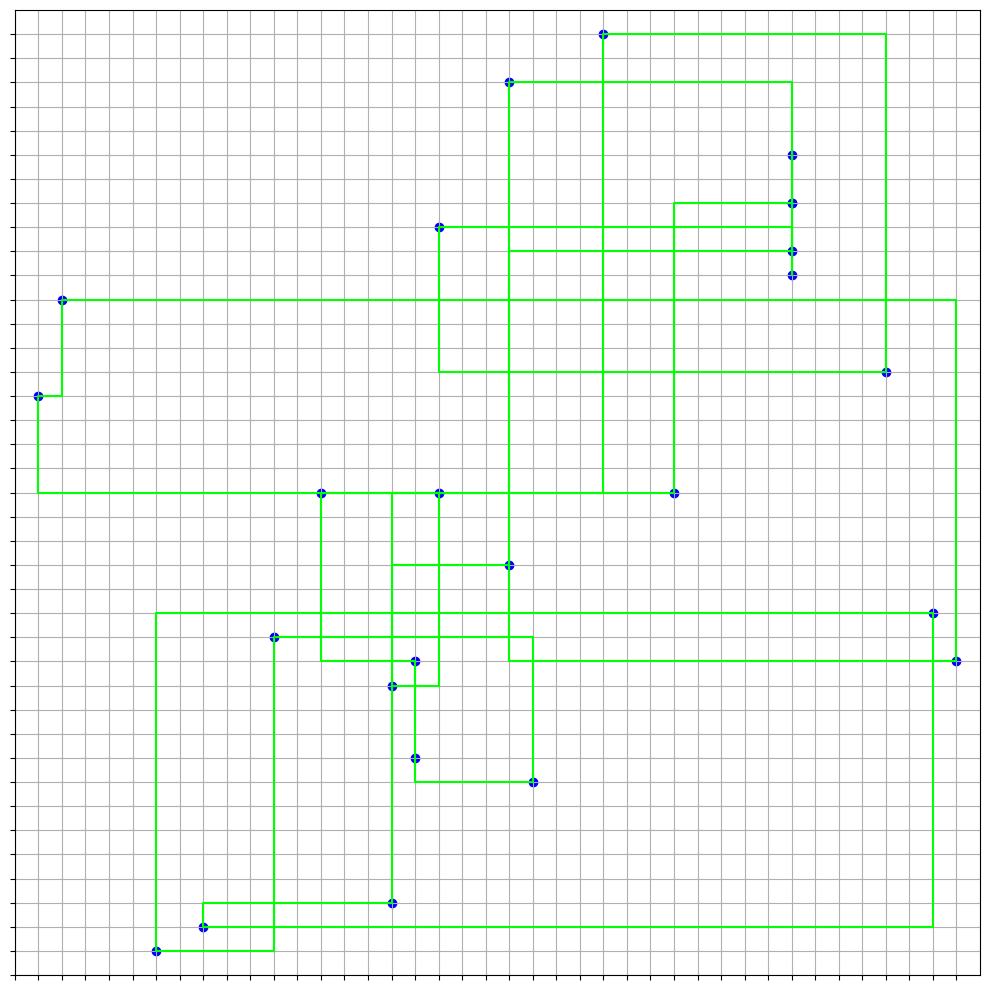

In [14]:
hillclimb = HillClimb(100, l1_distance)
HTML(visualize_hillclimb(X, hillclimb).to_jshtml())

### Задание 3 (2 балла)
Курьерское дело растет, теперь между городами блуждает большое количество курьеров, а их профессия вместе с известным маршрутом передается из поколение в поколение. Чем быстрее курьер способен обойти города - тем больше вероятность того, что он заработает себе на безоблачную старость и передаст свое дело потомкам. Симулируйте эволюцию курьеров, реализовав генетический алгоритм.

#### Методы
`optimize(X)` - выбирает лучшую перестановку из результатов `optimize_explain(X)`

`optimize_explain(X)` - возвращает список длины `iterations` популяций размера `population` перестановок точек `X`, полученных в процессе оптимизации. На каждом шаге алгоритм должен оставлять только `survivors` выживших, следующая популяция должна быть сгенерирована из них

#### Оценка
От 0.5 до 2 баллов в зависимости от оптимальности найденного решения.

In [ ]:
from task import Genetic

In [ ]:
gen = Genetic(200, 100, 20, l1_distance)
HTML(visualize_genetic(X, gen).to_jshtml())

### Задание 4 (2 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [ ]:
from task import BoW

In [ ]:
bow = BoW(X_spam_train, voc_limit=500)
X_train_bow = bow.transform(X_spam_train)
X_test_bow = bow.transform(X_spam_test)

### Задание 5 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [ ]:
from task import NaiveBayes

In [ ]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

In [ ]:
plot_precision_recall(X_spam_train, y_spam_train, X_spam_test, y_spam_test, BoW)